# Noise Reduction Benchmarking
Here, we compare three general noise reduction techniques to see which techniques improve the raw data in terms of discriminibility. We will then conclude which noise reduction is to be incorperated into the pipeline, and will give justification for such a decision.

### Discriminibility Setting
* Classes: The subject ID is used to separate classes here.
  * Number classes: 4.
* Trials: One trial is one EEG scan from the FCPI data set. 
  * Number trials: 11 for each class.
* Data derivitive which the metric is calculated with: We use three different derivitives
  * Frobenius Norm of Correlation Matricies\n",
    * Formal: $\delta(X, Y) = \vert\vert X - Y \vert\vert_{F} = \sqrt{\sum_{i, j}(X_{ij} - Y_{ij})^2}, X, Y \in \mathbb{R}^{C \times C}$ the correlation matricies.,
    * Why: In a resting state scan, the resting functional connectome for one subject will likely be more similar to that of another resting state scan from the same subject than one from a different subject.
  * Number of 3 cycles of the k-thresholded correlation matrix.,
    * Formal: $\delta_k(X, Y) = \vert trace((X > k - I)^3) - trace((Y > k - I)^3) \vert$, where $X, Y \in \mathbb{C \times C}$ are correlation matricies.
    * Why: Cyclical structures in a graph can give a notion of connectivity, as they form redundant connections. 3-cycles are very easy and fast to compute.
  * Number of 4 cycles of the k-thresholded correlation matrix.,
    * Formal: Let $C_4(A) = trace(A^4) + trace(A^2) -2\sum_{i=1}^n degree_A(v_i)$, then $\delta_k(X, Y) = \vert C_4(X) = C_4(Y)\vert$, where $X, Y \in \mathbb{R}^{C \times C}$ are correlation matricies.
    * Why: For the same reasons as 3 cycles, mostly added because it is also easy to compute.

### Key pre-processing routines:
* `raw` -- The 'raw' data from the CMI data set.
* `dbx` -- Wavelet coefficient thresholding using the Daubechies-$x$ wavelet.
* `px` -- Projection of the data matrix onto the first $x$ principal components calculated from the raw data matrix.
* `rpx` -- Projection of the data matrix onto the first $x$ principal components calculated from the low rank matrix resulting from the 'Principal Component Pursuit' sparse - low rank decomposition of the data matrix. (e.g. to remove gross outliers with sparse support).


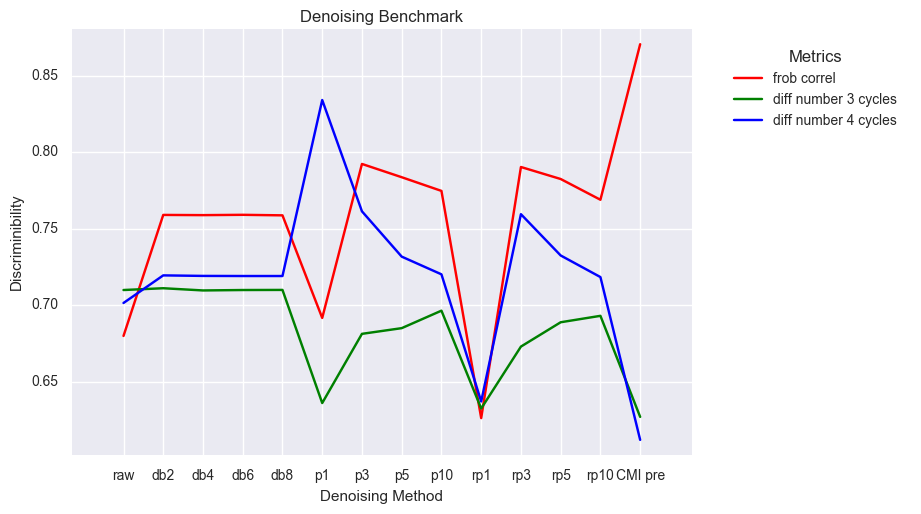

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def unpack(ls):
    names, tups = zip(*ls)
    dens = [list(zip(*x)[0]) for x in tups]
    return names, dens
# Get the data, values calculated on cortex
import cPickle as pkl
with open('distant/raw_no_denoise.pkl', 'rb') as f:
    res_raw = pkl.load(f)
    raw_values = list(zip(*res_raw)[1])
with open('distant/wavelet_denoise.pkl', 'rb') as f:
    res_den = pkl.load(f)
with open('distant/preprocessed.pkl', 'rb') as f:
    res_pre = pkl.load(f)
with open('distant/pca.pkl', 'rb') as f:
    res_pca = pkl.load(f)
with open('distant/rpca.pkl', 'rb') as f:
    res_rpca = pkl.load(f)
names, dens = unpack(res_den)
_, pre = unpack(res_pre)
pca_names, pca = unpack(res_pca)
pca_names = ['p' + str(x) for x in pca_names]
rpca_names, rpca = unpack(res_rpca)
rpca_names = ['rp' + str(x) for x in rpca_names]
dens.insert(0, raw_values)
dens.extend(pca)
dens.extend(rpca)
dens.extend(pre)
dens = np.array(dens).T
names = ['raw'] + list(names) + list(pca_names) + list(rpca_names) + ['CMI pre']

# Plotting
plt.plot(range(dens.shape[1]), dens[0, :], '-', color = 'red', label='frob correl')
plt.plot(range(dens.shape[1]), dens[1, :], '-', color = 'green', label = 'diff number 3 cycles')
plt.plot(range(dens.shape[1]), dens[2, :], '-', color = 'blue', label = 'diff number 4 cycles')
axes = plt.gca()
axes.set_ylim([np.min(dens) - .01, np.max(dens) + .01])
axes.margins(0.1, 0.1)
plt.ylabel('Discriminibility')
plt.xlabel('Denoising Method')
plt.title('Denoising Benchmark')
legend = plt.legend(title = 'Metrics', loc='upper center', bbox_to_anchor=(1.2,1), frameon=True, borderpad=1)
legend.get_frame().set_facecolor('white')
plt.xticks(range(dens.shape[1]), names)
plt.show()

### Discussion
From these experiments, the only denoising method that appears to increase discriminibility under all three metric / transform combinations are the Wavelet based denoising methods, db2 through db8. In a following plot, we will show a close up of the performance of the wavelet methods to show which one of this set performed the best.

From this experiment, it is of our opinion that Wavelet based denoising is superior and should be incorperated into the pipeline. This is mostly because it seems to be the most conservative denoising method, since it will not significantly decrease the discriminibility measure under any of the metric / transform combinations that we tested. Until we have a definitive reason that one of these methods of measuring discriminibility is superior to another, we will consider them all equally in testing the performance of preprocessing algorithms, and will consider a decrease under any of them from the raw measures as a bad thing.

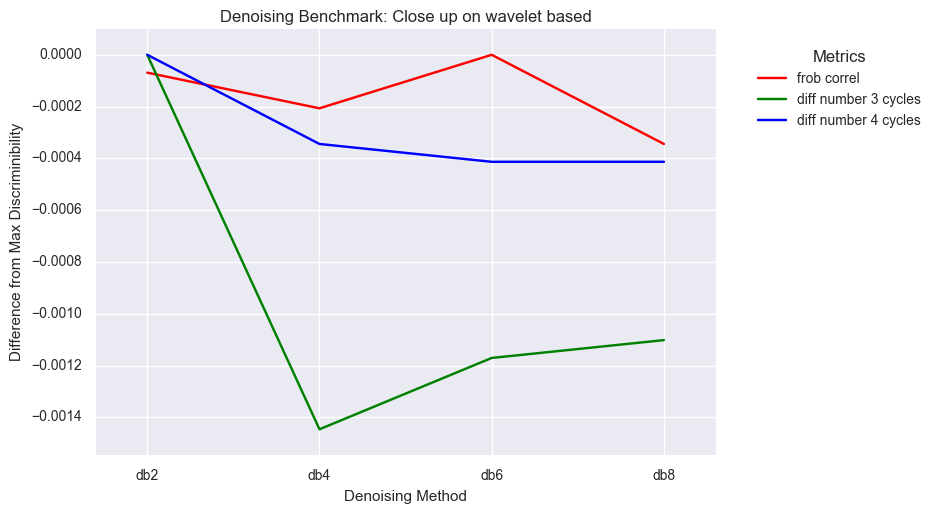

In [27]:
names, dens = unpack(res_den)
dens = np.array(dens).T
for i in range(dens.shape[0]):
    dens[i, :] = dens[i, :] - np.max(dens[i, :])
plt.plot(range(dens.shape[1]), dens[0, :], '-', color = 'red', label='frob correl')
plt.plot(range(dens.shape[1]), dens[1, :], '-', color = 'green', label = 'diff number 3 cycles')
plt.plot(range(dens.shape[1]), dens[2, :], '-', color = 'blue', label = 'diff number 4 cycles')
axes = plt.gca()
axes.set_ylim([np.min(dens) - .0001, np.max(dens) + .0001])
axes.margins(0.1, 0.1)
plt.ylabel('Difference from Max Discriminibility')
plt.xlabel('Denoising Method')
plt.title('Denoising Benchmark: Close up on wavelet based')
legend = plt.legend(title = 'Metrics', loc='upper center', bbox_to_anchor=(1.2,1), frameon=True, borderpad=1)
legend.get_frame().set_facecolor('white')
plt.xticks(range(dens.shape[1]), names)
plt.show()

### Final decision
Within the wavelet based denoising methods, it appears the best parameter setting is the db2 wavelet. This is also the fastest to compute, of any of the denoising methods listed, which is another bonus.